##Example Notebook:
###Testing FermiGates on Multi-Layer-Perceptrons on MNIST Dataset

#####Components:-
- One gated hidden layer (filter-wise = neuron-wise states)
- Low-rank interaction J = U @ U.T
- Small OrbitalBlock, SelfEnergyNet, TempNet
- Records mean occupancy P and test accuracy per epoch and plots them

This notebook is intended to run as a standalone script (requires torch, torchvision, matplotlib).
Designed to be small & clear to understand FermiGates

Note: This implementation does not include linear calibration

Epoch 01: loss=0.3256, mean P=0.9118, test acc=94.84%
Epoch 02: loss=0.1369, mean P=0.9344, test acc=96.48%
Epoch 03: loss=0.0926, mean P=0.9128, test acc=97.32%
Epoch 04: loss=0.0701, mean P=0.9177, test acc=97.63%
Epoch 05: loss=0.0537, mean P=0.8651, test acc=97.85%
Epoch 06: loss=0.0428, mean P=0.8564, test acc=97.51%
Epoch 07: loss=0.0347, mean P=0.8597, test acc=97.88%
Epoch 08: loss=0.0285, mean P=0.8656, test acc=97.66%
Epoch 09: loss=0.0224, mean P=0.8574, test acc=97.75%
Epoch 10: loss=0.0181, mean P=0.8602, test acc=97.75%
Epoch 11: loss=0.0148, mean P=0.8625, test acc=97.98%
Epoch 12: loss=0.0121, mean P=0.8785, test acc=97.74%
Epoch 13: loss=0.0098, mean P=0.8618, test acc=97.81%
Epoch 14: loss=0.0067, mean P=0.8835, test acc=97.82%
Epoch 15: loss=0.0047, mean P=0.9092, test acc=97.82%
Epoch 16: loss=0.0012, mean P=0.8974, test acc=97.54%
Epoch 17: loss=0.0025, mean P=0.8974, test acc=97.82%
Epoch 18: loss=-0.0016, mean P=0.8930, test acc=97.73%
Epoch 19: loss=-0.0027, mea

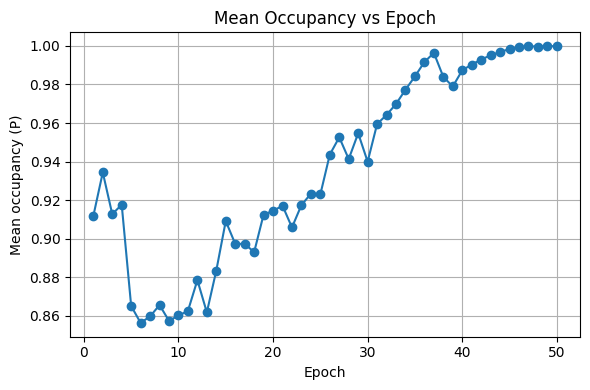

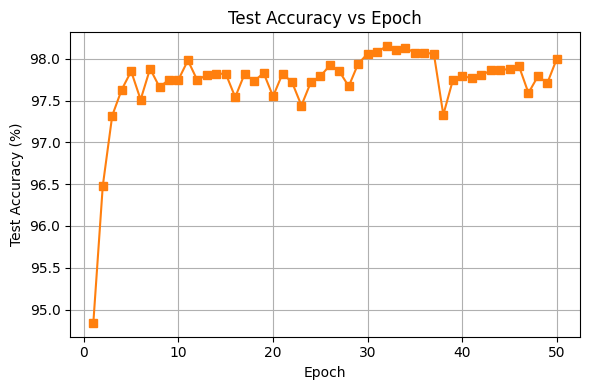

In [ ]:
"""
Minimal validation skeleton for the Interacting Orbital-Aware Fermi Gate.
- Simple MLP on MNIST
- One gated hidden layer (filter-wise = neuron-wise states)
- Low-rank interaction J = U @ U.T
- Small OrbitalBlock, SelfEnergyNet, TempNet
- Records mean occupancy P and test accuracy per epoch and plots them

Run as a standalone script (requires torch, torchvision, matplotlib).
Designed to be small & clear — use as a starting point for more elaborate experiments.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# Helper modules (tiny nets)
# --------------------------
class OrbitalBlock(nn.Module):
    """Produces a small orbital feature (scalar) per state from activation statistics."""
    def __init__(self, in_dim, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)   # scalar orbital_score
        )
    def forward(self, x):           # x: [batch, in_dim]
        # global avg pooling across batch to create a stable per-state signal
        s = x.mean(dim=0, keepdim=True)  # [1, in_dim]
        return self.net(s).squeeze(0)     # [1] -> scalar

class SmallMLP(nn.Module):
    def __init__(self, in_dim, hidden, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden, bias=True)
        self.fc2 = nn.Linear(hidden, out_dim)
        # gating-related submodules (per-hidden-neuron)
        self.orbital_blocks = nn.ModuleList([OrbitalBlock(in_dim) for _ in range(hidden)])
        self.self_energy_net = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 1))
        self.temp_net = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 1))
        # low-rank U for interaction: U shape (hidden, r)
        self.r = min(16, hidden)
        self.U = nn.Parameter(0.01 * torch.randn(hidden, self.r))
        # mu per-state (learnable threshold)
        self.mu = nn.Parameter(torch.zeros(hidden))
        # small alpha scaling for energy mapping
        self.alpha = nn.Parameter(torch.ones(1) * 0.5)

    def forward(self, x, P_prev):
        """
        x: [batch, in_dim]
        P_prev: [hidden] previous epoch occupancy estimate (or initial)
        returns logits, P_current (per-hidden neuron)
        """
        # bare energies: map weight magnitude (per row of fc1.weight)
        with torch.no_grad():
            W = self.fc1.weight.detach()  # [hidden, in_dim]
        eps = self.alpha * W.abs().mean(dim=1)   # [hidden]

        # flatten input for orbital blocks
        x_flat = x.view(x.size(0), -1)

        # orbital_score per hidden neuron (cheap approx using OrbitalBlock; returns [hidden, 1])
        orbital_scores = torch.stack([b(x_flat) for b in self.orbital_blocks]).squeeze(-1)  # [hidden]

        # Self-energy: take per-state vector [orbital_score, mean(P_prev)] -> scalar
        P_mean = P_prev.mean().detach()
        inp = torch.stack([orbital_scores, torch.full_like(orbital_scores, P_mean)], dim=1)  # [hidden,2]
        Sigma = self.self_energy_net(inp).squeeze(-1)   # [hidden]

        # Interaction term: J P_prev using low-rank J = U U^T => J P = U @ (U^T @ P)
        # Note: keep differentiable wrt U and P_prev
        UP = torch.matmul(self.U.t(), P_prev)          # [r]
        Interact = torch.matmul(self.U, UP)            # [hidden]

        # Temperature per-state
        T_raw = self.temp_net(inp).squeeze(-1)         # [hidden]
        T = F.softplus(T_raw) + 1e-6                   # positive

        # Compose z and compute P
        mu = self.mu                                      # [hidden]
        z = (eps - mu + Sigma + Interact) / T            # [hidden]
        P = 1.0 / (torch.exp(z) + 1.0)                   # [hidden] in (0,1)

        # apply gates to weights: broadcast P over input dim
        W_tilde = self.fc1.weight * P.view(-1, 1)        # [hidden, in_dim]
        # compute forward using gated weights (manually)
        x_flat = x.view(x.size(0), -1)                  # [batch, in_dim]
        hidden = F.linear(x_flat, W_tilde, self.fc1.bias)  # [batch, hidden]
        hidden = F.relu(hidden)
        logits = self.fc2(hidden)
        return logits, P

# --------------------------
# Data loaders (MNIST)
# --------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_loader = DataLoader(datasets.MNIST('.', train=True, download=True, transform=transform),
                          batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.MNIST('.', train=False, transform=transform),
                         batch_size=1000, shuffle=False)

# --------------------------
# Utilities: test function
# --------------------------
def test(model, device, loader, P_prev):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits, _ = model(x, P_prev)
            pred = logits.argmax(dim=1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    return correct / total

# --------------------------
# Training skeleton
# --------------------------
in_dim = 28*28
hidden = 128
out_dim = 10
model = SmallMLP(in_dim, hidden, out_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# initialize P_prev as sigmoid of eps (a warm starting guess)
with torch.no_grad():
    W0 = model.fc1.weight.data.clone()
    eps0 = model.alpha * W0.abs().mean(dim=1)
    P_prev = (1.0 / (torch.exp((eps0 - model.mu) / 1.0) + 1.0)).detach().to(device)

# logging
epochs = 50
avg_P_hist = []
acc_hist = []

lambda_F = 1e-4   # weight for free-energy term (tiny for skeleton)
lambda_sparsity = 1e-5

for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0.0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits, P = model(x, P_prev)    # P: [hidden]
        # task loss
        loss_task = F.cross_entropy(logits, y)

        # free-energy approx (simple): sum P*eps + 0.5 * P^T J P - T_avg * entropy(P)
        # compute eps (recompute from current weights)
        W = model.fc1.weight
        eps = model.alpha * W.abs().mean(dim=1)
        # interaction energy using low-rank U
        UP = torch.matmul(model.U.t(), P)
        JP = torch.matmul(model.U, UP)
        interaction_energy = 0.5 * (P * JP).sum()
        energy_term = (P * eps).sum()
        entropy = - (P * torch.log(P + 1e-8) + (1-P) * torch.log(1-P + 1e-8)).sum()
        T_avg = model.temp_net(torch.cat([eps.unsqueeze(1), P.mean().unsqueeze(0).repeat(eps.size(0),1)], dim=1)).abs().mean().detach()
        loss_F = energy_term + interaction_energy - (T_avg * entropy)

        # sparsity budget
        loss_sparsity = lambda_sparsity * P.sum()

        loss = loss_task + lambda_F * loss_F + loss_sparsity
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # after epoch, update P_prev (use latest P averaged across one pass)
    # compute P_prev by doing a forward on a small subset (cheap)
    model.eval()
    with torch.no_grad():
        x0, _ = next(iter(train_loader))
        x0 = x0.to(device)
        _, P_new = model(x0, P_prev)
        P_prev = P_new.detach()

    # evaluate
    avg_P = P_prev.mean().item()
    acc = test(model, device, test_loader, P_prev)
    avg_P_hist.append(avg_P)
    acc_hist.append(acc)
    print(f"Epoch {epoch:02d}: loss={epoch_loss/len(train_loader):.4f}, mean P={avg_P:.4f}, test acc={acc*100:.2f}%")

# --------------------------
# Plot results: mean occupancy & accuracy
# --------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), [p for p in avg_P_hist], marker='o')
plt.xlabel("Epoch")
plt.ylabel("Mean occupancy (P)")
plt.title("Mean Occupancy vs Epoch")
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), [a*100 for a in acc_hist], marker='s', color='tab:orange')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()

plt.show()